In [66]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm

In [5]:
if torch.cuda.is_available(): 
    device = 'gpu'    
else: device = 'cpu'

In [12]:
data_train = FashionMNIST(root = './',train = True, transform=  ToTensor(),  download=True)

In [13]:
data_test = FashionMNIST(root = './',train = False, transform=  ToTensor(),  download=True)

In [39]:
cat_dict = {0: 'T-shirt/top',1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

Text(0.5, 1.0, 'T-shirt/top')

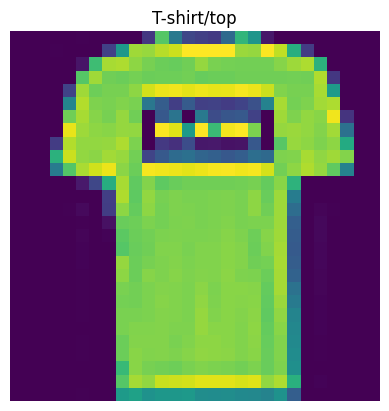

In [42]:
# load the data
X0, y0 = data_train.__getitem__(1)
fig, ax = plt.subplots()
ax.imshow(X0.squeeze())
ax.set_axis_off()
ax.set_title(cat_dict[y0])

In [45]:
# define dataloaders
batch_size = 32

train_data_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_data_loader  = DataLoader(data_test,  batch_size=batch_size, shuffle=False)

In [52]:
class model_0(nn.Module):
    def __init__(self, input_size: int, hiddenlayer_size: int, output_size: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= input_size, out_features= hiddenlayer_size),
            nn.ReLU(),
            nn.Linear(in_features=hiddenlayer_size, out_features= output_size),
            nn.Softmax()
        )
    def forward(self, X):  
        return self.layer_stack(X)

In [164]:
torch.manual_seed(543)
mod0 = model_0(input_size= 28*28, hiddenlayer_size= 20, output_size= len(cat_dict)).to(device)

In [165]:
lr = 0.1
optim     = torch.optim.SGD(params = mod0.parameters(), lr = lr)
loss_fn   = nn.BCELoss()

In [166]:
n_epochs = 30
num_epoch = []
losses_train = []
losses_test  = []
num_cats = len(cat_dict)
accuracy_train = []
accuracy_test = []


for epoch in tqdm(range(n_epochs)):
    loss_train = 0.0
    mod0.train()
    for (X,y) in train_data_loader:
        X, y = X.to(device), y.to(device) 
        y_pred = mod0(X)
        loss  = loss_fn(y_pred, nn.functional.one_hot(y, num_classes= num_cats).type(torch.float32))
        loss_train = loss_train + loss

        optim.zero_grad()
        loss.backward()
        optim.step() 
    loss_train = loss_train/len(train_data_loader)
    if (epoch%2)== 0:
        num_epoch.append(epoch)
        mod0.eval()
        with torch.inference_mode():
            losses_train.append(loss_train.detach().item())
            loss_test = 0
            acc = 0
            for (X,y) in test_data_loader:
                y_pred = mod0(X)
                loss_test = loss_test + loss_fn(y_pred, nn.functional.one_hot(y, num_classes= num_cats).type(torch.float32))
                acc = acc + (y_pred.argmax(dim=1) == y).sum()
            loss_test = loss_test/len(test_data_loader)
            losses_test.append(loss_test.detach().item())
            accuracy_test.append(acc/(len(test_data_loader)*batch_size))

100%|██████████| 30/30 [08:08<00:00, 16.27s/it]


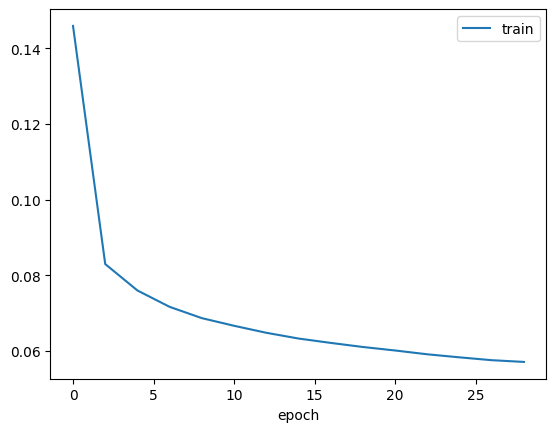

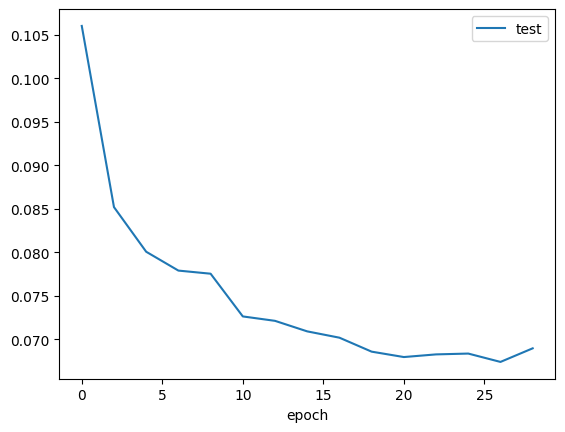

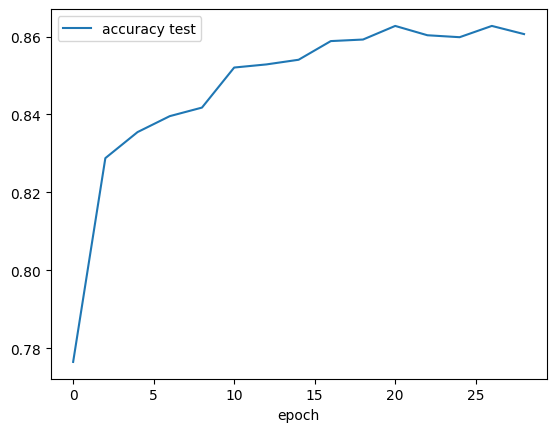

In [167]:
fig, ax = plt.subplots()
ax.plot(num_epoch, losses_train,label= 'train')
ax.set_xlabel('epoch')
ax.legend()


fig, ax = plt.subplots()
ax.plot(num_epoch,losses_test,label= 'test')
ax.set_xlabel('epoch')
ax.legend()


fig, ax = plt.subplots()
ax.plot(num_epoch, accuracy_test, label= 'accuracy test')
ax.set_xlabel('epoch')
ax.legend()




In [178]:
class CNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
      super().__init__()
      self.block1 =  nn.Sequential(
           nn.Conv2d(in_channels = input_shape,
                    out_channels= hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
           nn.ReLU(),
           nn.Conv2d(in_channels = hidden_units,
                    out_channels= hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=2,
                       stride=2)
           )
      self.block2 = nn.Sequential(
          nn.Conv2d(in_channels = hidden_units,
                    out_channels= hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels = hidden_units,
                    out_channels= hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)     
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape),
          nn.Softmax()              
     )
  def forward(self, X):
    return self.classifier(self.block2(self.block1(X)))

In [179]:
torch.manual_seed(42)
mod_1 = CNN(input_shape=1, hidden_units= 10, output_shape= len(cat_dict)).to(device)

In [189]:
lr = 0.1
optim     = torch.optim.SGD(params = mod_1.parameters(), lr = lr)
loss_fn   = nn.BCELoss()

In [190]:
n_epochs = 30
num_epoch = []
losses_train = []
losses_test  = []
num_cats = len(cat_dict)
accuracy_train = []
accuracy_test = []

for epoch in tqdm(range(n_epochs)):
    loss_train = 0.0
    mod_1.train()
    for (X,y) in train_data_loader:
        X, y = X.to(device), y.to(device) 
        y_pred = mod_1(X)
        loss  = loss_fn(y_pred, nn.functional.one_hot(y, num_classes= num_cats).type(torch.float32))
        loss_train = loss_train + loss

        optim.zero_grad()
        loss.backward()
        optim.step() 
    loss_train = loss_train/len(train_data_loader)
    if (epoch%2)== 0:
        num_epoch.append(epoch)
        mod_1.eval()
        with torch.inference_mode():
            losses_train.append(loss_train.detach().item())
            loss_test = 0
            acc = 0
            for (X,y) in test_data_loader:
                y_pred = mod_1(X)
                loss_test = loss_test + loss_fn(y_pred, nn.functional.one_hot(y, num_classes= num_cats).type(torch.float32))
                acc = acc + (y_pred.argmax(dim=1) == y).sum()
            loss_test = loss_test/len(test_data_loader)
            losses_test.append(loss_test.detach().item())
            accuracy_test.append(acc/(len(test_data_loader)*batch_size))


100%|██████████| 30/30 [28:30<00:00, 57.01s/it]


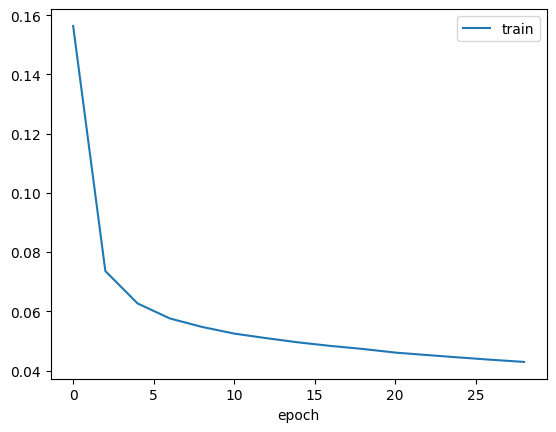

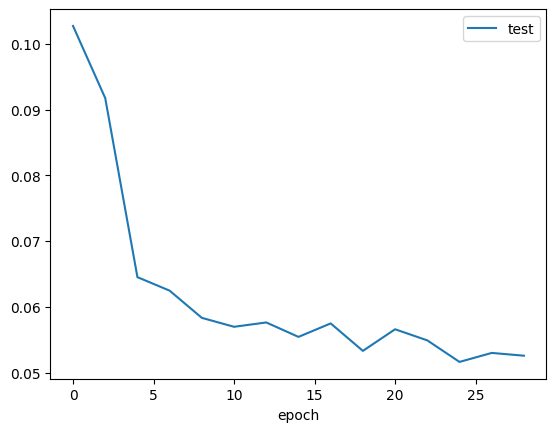

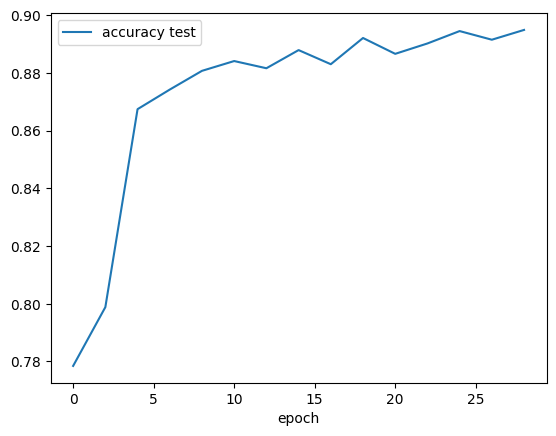

In [191]:
fig, ax = plt.subplots()
ax.plot(num_epoch, losses_train,label= 'train')
ax.set_xlabel('epoch')
ax.legend()


fig, ax = plt.subplots()
ax.plot(num_epoch,losses_test,label= 'test')
ax.set_xlabel('epoch')
ax.legend()


fig, ax = plt.subplots()
ax.plot(num_epoch, accuracy_test, label= 'accuracy test')
ax.set_xlabel('epoch')
ax.legend()

